# 11-830 HW3: Advanced Analysis

## Setup

In [671]:
import re
import string
import collections

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from tqdm.notebook import tqdm

np.random.seed(11830)

import warnings
warnings.filterwarnings('ignore')

import nltk

In [672]:
df = pd.read_csv('data/background_large.csv')

In [673]:
# We don't need any other columns

df = df[['post_text', 'op_gender', 'subreddit']]

## Step 1: Preprocess and explore the data

In [674]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
 
nltk_stop_words = set(stopwords.words('english'))
stop_words = set(stopwords.words('english'))
remove = ['he', 'her', 'hers', 'herself', 'him', 'himself', 'his', 'she', "she's"]
for word in remove:
    stop_words.remove(word)

In [675]:
df.head()

,post_text,op_gender,subreddit
0,slayer task perhaps?,M,2007scape
1,"Black DHide legs, possibly an initiate pure?",M,2007scape
2,Whats a tonk? lol,M,2007scape
3,Do the Stronghold of Security for a free 10k t...,M,2007scape
4,I cant tell if this guy just doesnt speak Engl...,M,2007scape


AxesSubplot(0.125,0.125;0.775x0.755)


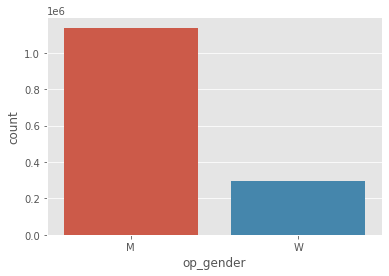

In [1300]:
sns.countplot(df.op_gender)

In [676]:
N = len(df)
N

1431512

<AxesSubplot:xlabel='op_gender', ylabel='count'>

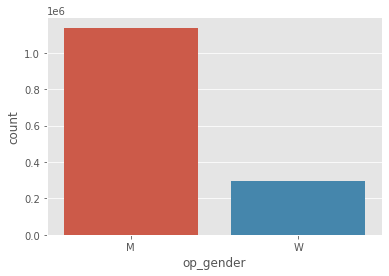

In [677]:
sns.countplot(df.op_gender)

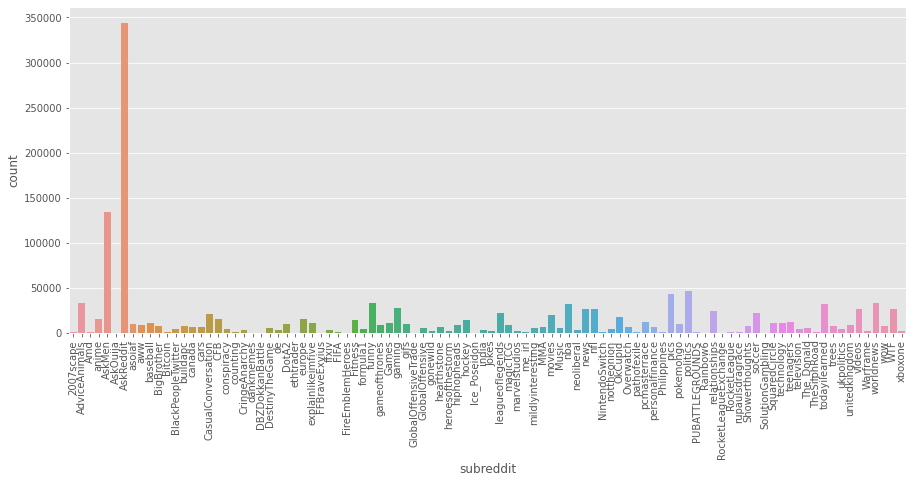

In [678]:
plt.figure(figsize=(15,6))
sns.countplot(df.subreddit)
plt.xticks(rotation=90)
plt.show()

In [679]:
from nltk.tokenize import word_tokenize, RegexpTokenizer

def preprocess(sentence):
    if isinstance(sentence, float):
        return []
    else:
        sentence = sentence.lower()
        tokenized = re.findall(r'[^\W_]+', sentence)
        return tokenized
    
print(preprocess('Thats what I normally do but that toilet doesnt have a lid.'))

['thats', 'what', 'i', 'normally', 'do', 'but', 'that', 'toilet', 'doesnt', 'have', 'a', 'lid']


In [680]:
test = [x[0] for x in df[df.op_gender=='W'].head(10).values]

In [681]:
import pickle

cache_name = 'data/gender_classifier.pickle'

def get_preds(cache_name, test):
    m,v = pickle.load(open(cache_name, 'rb'))
    test = [" ".join(word_tokenize(t)) for t in tqdm(test)]
    test_data_features = v.transform(test)
    # print(test_data_features)
    preds = m.predict(test_data_features)
    return preds

get_preds(cache_name, test)

array(['M', 'M', 'W', 'W', 'M', 'M', 'W', 'W', 'M', 'M'], dtype='<U1')

In [682]:
preprocessed_text = []

count = 0
for text in tqdm(df.post_text.values):
    text = preprocess(text)
    preprocessed_text.append(text)
    count += 1
#     print(str(count) + ' out of ' + str(N) + ' processed.', end='\r')
    
df['text'] = preprocessed_text
    
# df['text'] = df['post_text'].map(preprocess)

In [683]:
df.head()

,post_text,op_gender,subreddit,text
0,slayer task perhaps?,M,2007scape,"[slayer, task, perhaps]"
1,"Black DHide legs, possibly an initiate pure?",M,2007scape,"[black, dhide, legs, possibly, an, initiate, p..."
2,Whats a tonk? lol,M,2007scape,"[whats, a, tonk, lol]"
3,Do the Stronghold of Security for a free 10k t...,M,2007scape,"[do, the, stronghold, of, security, for, a, fr..."
4,I cant tell if this guy just doesnt speak Engl...,M,2007scape,"[i, cant, tell, if, this, guy, just, doesnt, s..."


## Step 1: Compute the word associations

Compute $Assoc(w_i, y)$ for each $w_i \in \textbf{w}$, defined as follows

$$
\begin{equation}
PMI(w_i, y_1) = \log\dfrac{ P(w_i, y_1)}{P(w_i)P(y_1)} = \log \dfrac{N \cdot count(w_i, y_1)}{count(w_i)count(y_1)}\\
nPMI(w_i, y_1) = \dfrac{PMI(w_i, y_1)}{-\log P(w_i, y_1)} \\
Assoc(w_i, y_1) = nPMI(w_i, y_1) - nPMI(w_i, y_2)
\end{equation}
$$

In [684]:
word_counts = {}

for sentence in tqdm(df.text.values):
    for word in sentence:
        word_counts[word] = word_counts.get(word, 0) + 1

Get the PMIs and associations for male and female words

In [685]:
# uncomment this line to get PMI from entire dataset
# df = small

word_counts = {}

for sentence in tqdm(df.text.values):
    for word in sentence:
        word_counts[word] = word_counts.get(word, 0) + 1
        
word_counts_W = {}
word_counts_M = {}

countW = 0
countM = 0

for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    gender = row.op_gender
    sentence = row.text
    
    if gender == 'W':
        countW += 1
        for word in sentence:
            word_counts_W[word] = word_counts_W.get(word, 0) + 1
            
    elif gender == 'M':
        countM += 1
        for word in sentence:
            word_counts_M[word] = word_counts_M.get(word, 0) + 1
            
N = len(df)

def get_PMI_W(word):
    if word not in word_counts_W or word not in word_counts:
        return 0.0
    pmi = np.log2( (N * word_counts_W[word]) / (word_counts[word] * countW) )
    npmi = pmi / -np.log2(word_counts_W[word] / N)
    return npmi

def get_PMI_M(word):
    if word not in word_counts_M or word not in word_counts:
        return 0.0
    pmi = np.log2( (N * word_counts_M[word]) / (word_counts[word] * countM) )
    npmi = pmi / -np.log2(word_counts_M[word] / N)
    return npmi

PMI_W = {}
PMI_M = {}

for word in tqdm(word_counts_W):
    PMI_W[word] = get_PMI_W(word)
    
for word in tqdm(word_counts_M):
    PMI_M[word] = get_PMI_M(word)
    
def assoc_M(word):
    return get_PMI_M(word) - get_PMI_W(word)

def assoc_W(word):
    return get_PMI_W(word) - get_PMI_M(word)

In [686]:
a = [(k,v) for (k,v) in PMI_W.items()]
a.sort(key=lambda x: x[1], reverse=True)
print(a[:10])

[('i', 0.21073535502446478), ('husband', 0.20439935725309047), ('boyfriend', 0.20094781695137987), ('tiff', 0.18871135652696056), ('my', 0.17223294048089982), ('paulie', 0.1705672017265664), ('nicole', 0.1696943784923473), ('ゴ', 0.1616769504199393), ('bridgette', 0.15790451807459063), ('bronte', 0.15539066641437219)]


In [687]:
a = [(k,v) for (k,v) in PMI_M.items()]
a.sort(key=lambda x: x[1], reverse=True)
print(a[:10])

[('team', 0.03614724976653924), ('bwoah', 0.03402266201679053), ('lebron', 0.033644268804065), ('game', 0.033173559506553395), ('teams', 0.03303553721840338), ('players', 0.032588838698356944), ('nba', 0.032392230134440675), ('qb', 0.032120333484497186), ('player', 0.03180915319331963), ('playoffs', 0.031614579652277916)]


Get subreddit PMIs

In [688]:
subreddits = df.subreddit.unique()
subreddit_idx = {subreddit:i for (i, subreddit) in enumerate(subreddits)}

subreddit_counts = []

for i in range(len(subreddits)):
    subreddit_counts.append({})
    
subreddit_pmis = []

for i in range(len(subreddits)):
    subreddit_pmis.append({})
    
for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    subreddit = row.subreddit
    sentence = row.text

    s_id = subreddit_idx[subreddit]
    dic = subreddit_counts[s_id]

    for word in sentence:
        dic[word] = dic.get(word, 0) + 1
        
subcounts = collections.Counter(df.subreddit.values)

N = df.shape[0]

for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    subreddit = row.subreddit
    sentence = row.text

    s_id = subreddit_idx[subreddit]
    pmi_dic = subreddit_pmis[s_id]
    dic = subreddit_counts[s_id]

    for word in sentence:
        if word not in dic or word not in word_counts:
            pmi_dic[word] = 0.0
        else:
            pmi = np.log2( (N * dic[word]) / (word_counts[word] * subcounts[subreddit]) )
            npmi = pmi / -np.log2(word_counts[word] / N)
            pmi_dic[word] = npmi
            
            
def get_subreddit_pmi(word, subreddit):
    if word not in subreddit_pmis[subreddit_idx[subreddit]]:
        return 0.0
    return subreddit_pmis[subreddit_idx[subreddit]][word]

In [689]:
dic = subreddit_pmis[subreddit_idx['funny']]
a = [(k,v) for (k,v) in dic.items() if k not in stop_words]
a.sort(key=lambda x: x[1], reverse=True)
print(a[:10])

[('dys', 0.31604508595649106), ('coms', 0.3000968946270709), ('marpat', 0.3000828268473686), ('ombs', 0.2994852349435524), ('20ppm', 0.2994852349435524), ('omnipotence', 0.295160737632106), ('õ', 0.2942593611837116), ('mbuti', 0.2942593611837116), ('kiwirail', 0.2942593611837116), ('tenty', 0.2942593611837116)]


In [690]:
dic = subreddit_pmis[subreddit_idx['relationships']]
a = [(k,v) for (k,v) in dic.items() if k not in stop_words]
a.sort(key=lambda x: x[1], reverse=True)
print(a[:10])

[('her', 0.9098208360872232), ('she', 0.844923809390066), ('he', 0.808002749417573), ('him', 0.6932556198086499), ('relationship', 0.6378117766406993), ('his', 0.5295596271200694), ('shes', 0.5174926509938286), ('op', 0.5136562686979714), ('want', 0.501558261721448), ('dont', 0.49652777161599276)]


## Step 2: Create the vocabulary
Let the initial label be M and we want to classify it as W. The target label y is W. \
Collect a vocabulary $V$ where \
$$
\begin{equation}
v \in V \iff SynSem(w_i, v) > \tau \land Assoc(v, y) > Assoc(w, y) \land Assoc(v, y) > 0
\end{equation}
$$
The syntactic similarity $SynSem$ between $w_i$ and $v$ is defined as the cosine similarity between the dependency-parse-based Word2Vec.


In [691]:
import gensim
import gensim.downloader

In [692]:
model = gensim.models.KeyedVectors.load_word2vec_format('data/deps.words.bin', binary=True)

In [693]:
glove_vectors = gensim.downloader.load('glove-twitter-200')

In [694]:
normal_w2v = gensim.downloader.load('word2vec-google-news-300')

In [695]:
model.most_similar("eating", topn=10)

[('chewing', 0.738322377204895),
 ('sipping', 0.7307297587394714),
 ('swallowing', 0.7290360331535339),
 ('ingesting', 0.7152209877967834),
 ('grilling', 0.7130779027938843),
 ('snorting', 0.7069267630577087),
 ('roasting', 0.7034690976142883),
 ('stewing', 0.7015069127082825),
 ('milking', 0.6970013380050659),
 ('snacking', 0.6960674524307251)]

In [696]:
glove_vectors.most_similar("niggas", topn=10)

[('niggaz', 0.9132169485092163),
 ('bitches', 0.8809657692909241),
 ('hoes', 0.8683807253837585),
 ('nigga', 0.8659803867340088),
 ('yall', 0.8641895055770874),
 ('mfs', 0.824196994304657),
 ('aint', 0.8114688396453857),
 ('females', 0.8007972240447998),
 ('niggahs', 0.7884033918380737),
 ('these', 0.7840491533279419)]

In [1333]:
def synsem(w, threshold=0.7):
    if w in model.key_to_index:
        most_similar = model.most_similar(w, topn=50)
    elif w in glove_vectors.key_to_index:
        most_similar = glove_vectors.most_similar(w, topn=50)
    else:
        most_similar = []
        
    candidates = []
    for word, sim in most_similar:
        if sim >= threshold:
            candidates.append((word, sim))
            
    while len(candidates) < 5 and threshold > 0.6:
        candidates = []
        threshold=threshold-0.05
        for word, sim in most_similar:
            if sim >= threshold:
                candidates.append((word, sim))
                
    return candidates

In [1073]:
synsem('dinner')

[('luncheon', 0.7911155819892883),
 ('banquet', 0.7542293667793274),
 ('lunch', 0.7398091554641724),
 ('breakfast', 0.7382199764251709),
 ('dinners', 0.7193452715873718),
 ('brunch', 0.7002900242805481)]

In [1074]:
def get_subreddit_assoc(word, subreddit):
    opp = "relationships" if subreddit == "funny" else "funny"
    subreddit_pmi = get_subreddit_pmi(word, subreddit) - get_subreddit_pmi(word, opp)
    return subreddit_pmi

In [1075]:
get_subreddit_assoc('nigga', 'relationships')

-0.07591617626009621

In [1308]:
def get_vocab(word, target_label, exclude=[], subreddit=None):
    candidates = synsem(word)
    assocfn = assoc_W if target_label == 'W' else assoc_M
    vocab = []
    for cand, sim in candidates:
        #print(cand, sim)
        #print(assocfn(cand))
        #print(assocfn(word))
        if assocfn(cand) > assocfn(word) and assocfn(cand) > 0 and cand not in exclude:
            if subreddit != None:
#                 subreddit_assoc = get_subreddit_assoc(word, subreddit)
                if get_subreddit_assoc(cand, subreddit) > 0:
                    #print(get_subreddit_assoc(cand, subreddit))
                    vocab.append((cand, sim))
            else:
                vocab.append((cand, sim))
            
    return vocab

In [1077]:
get_vocab("nigga", "W", subreddit="funny")

[('twat', 0.8545702695846558),
 ('whoop', 0.8227294683456421),
 ('ooh', 0.8167010545730591),
 ('chav', 0.8132428526878357),
 ('weenie', 0.810501754283905)]

# Step 3: compute substitutability

Select candidate $v \in V$ that is most similar and substitutable to $w_i$ and substitute. \
Given candidate $a \in V$, original word $b$ and context $C$ where $C$ contains the words to the left and right of $b$, substitutability is defined as \
$$
\begin{equation}
Subst(a,b,C) = \dfrac{SynSem(a,b) + \sum_{c \in C} Sem(a,c)}{|C| + 1}
\end{equation}
$$
Where $Sem(a,c)$ is the regular Word2Vec cosine similarity.

In [1404]:
def subst(a, b, synsem, left=None, right=None):

    
    context = 0
    dic = None
    if a in normal_w2v.key_to_index:
        dic = normal_w2v
    elif a in glove_vectors.key_to_index:
        dic = glove_vectors
    
    
    else:
        dic = model
    
    if left and right and left in dic.key_to_index and right in dic.key_to_index:
        context += dic.similarity(a, left)
        context += dic.similarity(a, right)
        subst = (synsem + context) / (2+1)
        
    elif left and not right and left in dic.key_to_index:
        context += dic.similarity(a, left)
        subst = (synsem + context) / (1+1)
        
    elif right and not left and right in dic.key_to_index:
        context += dic.similarity(a, right)
        subst = (synsem + context) / (1+1)
        
    else:
        return synsem
    
    return subst

In [1405]:
vs = get_vocab("niggas", "W", subreddit="funny")
for v, sim in vs:
    print(v, subst(v, "niggas", sim, left="my", right="look"))

bitches 0.41784777243932086
bitch 0.3670524060726166
kno 0.3816079298655192
chicks 0.2895541662971179


## Step 4: define obfuscation function

In [1184]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
 
stop_words = set(stopwords.words('english'))
remove = ['he', 'her', 'hers', 'herself', 'him', 'himself', 'his', 'she', "she's"]
for word in remove:
    stop_words.remove(word)
# stop_words

In [1185]:
get_subreddit_pmi('girlfriend', 'relationships') - get_subreddit_pmi('girlfriend', 'funny')

0.4894689650546808

In [1406]:
def get_closest(target_word, wordlist):
    cands = []
    for word in wordlist:
        if target_word in normal_w2v.key_to_index and word in normal_w2v.key_to_index and word != target_word:
            cands.append((word, normal_w2v.similarity(word, target_word)))
    if cands == []:
        return target_word
    cand, sim = sorted(cands, key=lambda x: x[1], reverse=True)[0]
    if sim > 0.7:
        return cand
    else:
        return target_word

In [1407]:
get_closest('husband', female_words)

'mother'

In [1188]:
sent = "definitely would recommend".split()
[get_subreddit_pmi(x, "funny") for x in sent]

[-0.09323576429616412, -0.1915033915824524, -0.08188750348068258]

In [1271]:
def obfuscate(sentence, target_label, subreddit=None):
    # assumption: sentence is lowercased and tokenized
    final = []
    assocfn = assoc_W if target_label == 'W' else assoc_M
    wordlist = female_words if target_label == 'M' else male_words
    
    for i in range(len(sentence)):            

        word = sentence[i]
        subreddit_pmi = 0.0
        if subreddit != None:
            opp = "relationships" if subreddit == "funny" else "funny"
            subreddit_pmi = get_subreddit_pmi(word, subreddit) - get_subreddit_pmi(word, opp)
        else:
            subreddit_pmi = 0.0
        
        exclude = []
        left = None
        right = None 
        
        if i != 0 and i != (len(sentence)-1):
            exclude.append(sentence[i-1])
            exclude.append(sentence[i+1])
            left = sentence[i-1]
            right = sentence[i+1]
        elif i != 0:
            exclude.append(sentence[i-1])
            left = sentence[i-1]
        elif i != (len(sentence)-1):
            exclude.append(sentence[i+1])
            right = sentence[i+1]

        if len(final) != 0:
            exclude.append(final[-1])
            
        # replace if the word is indicative of the opposite label
        if (assocfn(word) < 0.03 or word in wordlist) and word not in stop_words:
        #if assocfn(word) < 0:
            #print(subreddit_pmi)
            vocab = get_vocab(word, target_label, exclude, subreddit)
            #print(vocab)
            candidates = []
            for v, sim in vocab:
                subs = subst(v, word, sim, left, right)
                candidates.append((v, subs))
            if candidates == []:
                final.append(get_closest(word, wordlist))
            else:
                #print(sorted(candidates, key=lambda x: x[1], reverse=True))
                replacement = sorted(candidates, key=lambda x: x[1], reverse=True)[0][0]
                final.append(replacement)
            
        else:
            final.append(word)
            
    return ' '.join(final)

In [1272]:
subreddit = "relationships"
word = "nigga"
opp = "relationships" if subreddit == "funny" else "funny"
subreddit_assoc = get_subreddit_pmi(word, subreddit) - get_subreddit_pmi(word, opp)
subreddit_assoc

-0.07591617626009621

In [1273]:
get_subreddit_assoc("father", "funny")

-0.37642514066358823

In [1274]:
sent = "All my niggas look rich as fuck"
sent = nltk.word_tokenize(sent.lower())
obfuscate(sent, "W", subreddit="relationships")

'all my females looked rich as shit'

In [1275]:
sent = 'the girls who work there are wonderful'
sent = nltk.word_tokenize(sent.lower())
obfuscate(sent, "M")

'the boys who today there are marvellous'

In [1276]:
test_sentences = ['took my friend here', 'definitely would recommend', 'and I was impressed',
                  'the girls who work there are wonderful', 'PK was our server',
                  'the creamy rice side dish - delish']

for sent in test_sentences:
    target = 'M'
    sent = sent.split()
    print(obfuscate(sent, target))

gave my colleague here
certainly whould reccomend
and I was unimpressed
the boys who today there are marvellous
PK was our servers
the papery yams sides dish - delicious


In [1290]:
test_sentences = ['exceptional view, excellent service, great quality and the food still outstanding',
                  'my wife and i can\'t wait to go back',
                  'i like burgers a lot',
                  'i like video games',
                  'i want to go shopping']

for sent in test_sentences:
    target = 'W'
    sent = sent.split()
    print(obfuscate(sent, target))

admirable view, great service, good quality and the lunch still exceptional
my girlfriend and i can't waited to go back
i like cupcakes a alot
i like youtube game
i want to go shopping


In [1278]:
obfuscate("the drinks are great".split(), "W")

'the drinks are good'

In [1279]:
obfuscate("the drinks are wonderful".split(), "M")

'the drink are marvellous'

In [1280]:
sent = "my dad needed that sign when he forced me on a roller coaster"
obfuscate(sent.split(), "M")

'my granddad needed that sign when him enticed me on a roller coaster'

## Step 5: obfuscate everything in the dataset

In [1281]:
small = pd.read_csv('data/dataset.csv')

In [1282]:
preprocessed_text = []

count = 0
for text in tqdm(small.post_text.values):
    text = preprocess(text)
    #text = text.split(' ')
    #text = [token.lower() for token in text if token != '']
    preprocessed_text.append(text)
    count += 1
#     print(str(count) + ' out of ' + str(N) + ' processed.', end='\r')
    
small['text'] = preprocessed_text

In [1283]:
small.head()

,Unnamed: 0,op_id,op_gender,post_id,post_text,subreddit,op_gender_visible,text
0,1200978,MexicanSpaceProgram,M,1200978,It really comes down to the circumstances unde...,relationships,False,"[it, really, comes, down, to, the, circumstanc..."
1,747542,urmyheartBeatStopR,M,747542,"S.Korea, Japan, & China have tons of boy bands...",funny,False,"[s, korea, japan, china, have, tons, of, boy, ..."
2,721771,MadHatter69,M,721771,Those eyes.,funny,False,"[those, eyes]"
3,727114,on_the_redpill,M,727114,you need shades (Its not my fault if you keep...,funny,False,"[you, need, shades, its, not, my, fault, if, y..."
4,737662,oranjeeleven,M,737662,Nope.,funny,False,[nope]


In [1291]:
obfuscated_text = []

for i, row in tqdm(small.iterrows(), total=2000):
    #print(row)
    sent = row.text
    original = row.op_gender
    subreddit = row.subreddit
    target = "M" if original=="W" else "W"
    obfuscated = obfuscate(sent, target)
    obfuscated_text.append(obfuscated)

small['obfuscated_text'] = obfuscated_text

In [1292]:
save_df = pd.DataFrame()
save_df['op_gender'] = small['op_gender']
save_df['post_text'] = small['obfuscated_text']
save_df['subreddit'] = small['subreddit']

In [1293]:
save_df.to_csv('data/save_df_glove_reddit.csv')

In [1294]:
! cd data; python classify.py --test save_df_glove_reddit.csv

/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
1

In [1295]:
small

,Unnamed: 0,op_id,op_gender,post_id,post_text,subreddit,op_gender_visible,text,obfuscated_text
0,1200978,MexicanSpaceProgram,M,1200978,It really comes down to the circumstances unde...,relationships,False,"[it, really, comes, down, to, the, circumstanc...",it really came down to the circumstances under...
1,747542,urmyheartBeatStopR,M,747542,"S.Korea, Japan, & China have tons of boy bands...",funny,False,"[s, korea, japan, china, have, tons, of, boy, ...",s thailand tokyo thailand have tonnes of boy b...
2,721771,MadHatter69,M,721771,Those eyes.,funny,False,"[those, eyes]",those eyes
3,727114,on_the_redpill,M,727114,you need shades (Its not my fault if you keep...,funny,False,"[you, need, shades, its, not, my, fault, if, y...",you should shades its not my fault if you keep...
4,737662,oranjeeleven,M,737662,Nope.,funny,False,[nope],nope
...,...,...,...,...,...,...,...,...,...
1995,718538,EgregiousWeasel,W,718538,Ill bet youre fun at parties.,funny,False,"[ill, bet, youre, fun, at, parties]",sure bet somone night at party
1996,719932,OhMyMoogle,W,719932,Well they keep their clothes on... so theres t...,funny,False,"[well, they, keep, their, clothes, on, so, the...",but they always their sunglasses on so cuz that
1997,1211454,Birdy1072,W,1211454,> There is no reasoning with this sub. This su...,relationships,False,"[there, is, no, reasoning, with, this, sub, th...",there is no argumentation with this sub this s...
1998,719803,palpablescalpel,W,719803,Some people like to work outside. Many of the ...,funny,False,"[some, people, like, to, work, outside, many, ...",some bolivians just to today there numerous of...


## Step 6: Test with PMI with only small dataset

In [317]:
small_word_counts = {}

for sentence in tqdm(small.text.values):
    for word in sentence:
        small_word_counts[word] = small_word_counts.get(word, 0) + 1

In [318]:
len(small[small.subreddit == 'funny']), len(small[small.subreddit == 'relationships'])

(1052, 948)

In [319]:
count_funny = len(small[small.subreddit == 'funny'])
count_rel = len(small[small.subreddit == 'relationships'])

In [320]:
word_counts_funny = {}
word_counts_rel = {}

for i, row in tqdm(small.iterrows(), total=small.shape[0]):
    subreddit = row.subreddit
    sentence = row.text
    
    if subreddit == "funny" or "funny" in sentence:
        for word in sentence:
            word_counts_funny[word] = word_counts_funny.get(word, 0) + 1
            
    elif subreddit == "relationships" or "relationship" in sentence or "relationships" in sentence:
        for word in sentence:
            word_counts_rel[word] = word_counts_rel.get(word, 0) + 1

In [321]:
N = len(small)
N

2000

In [322]:
def get_PMI_funny(word):
    if word not in word_counts_funny or word not in small_word_counts:
        return 0.0
    pmi = np.log2( (N * word_counts_funny[word]) / (small_word_counts[word] * count_funny) )
    npmi = pmi / -np.log2(word_counts_funny[word] / N)
    return npmi

In [323]:
def get_PMI_rel(word):
    if word not in word_counts_rel or word not in small_word_counts:
        return 0.0
    pmi = np.log2( (N * word_counts_rel[word]) / (small_word_counts[word] * count_rel) )
    npmi = pmi / -np.log2(word_counts_rel[word] / N)
    return npmi

In [324]:
PMI_funny = {}
PMI_rel = {}

for word in tqdm(word_counts_funny):
    PMI_funny[word] = get_PMI_funny(word)
    
for word in tqdm(word_counts_rel):
    PMI_rel[word] = get_PMI_rel(word)
    
def assoc_funny(word):
    return get_PMI_funny(word) - get_PMI_rel(word)

def assoc_rel(word):
    return get_PMI_rel(word) - get_PMI_funny(word)

In [325]:
a = [(k,v) for (k,v) in PMI_funny.items() if k not in stop_words]
a.sort(key=lambda x: x[1], reverse=True)
print(a[:20])

[('0', 0.15056085792434684), ('funny', 0.15050351977696483), ('tobacco', 0.11889199916227569), ('mos', 0.11635581158712018), ('colorblind', 0.11635581158712018), ('soccer', 0.11360830059008978), ('boy', 0.11059360516958075), ('karma', 0.11059360516958075), ('pts', 0.11059360516958075), ('windows', 0.11059360516958075), ('gif', 0.11059360516958075), ('australia', 0.11059360516958075), ('feminists', 0.11059360516958075), ('3232', 0.11059360516958075), ('arms', 0.11059360516958075), ('german', 0.11059360516958075), ('ally', 0.11059360516958075), ('retarded', 0.10722821794122658), ('music', 0.10722821794122658), ('equality', 0.10722821794122658)]


In [326]:
a = [(k,v) for (k,v) in PMI_rel.items() if k not in stop_words]
a.sort(key=lambda x: x[1], reverse=True)
print(a[:20])

[('her', 0.8959239739838645), ('she', 0.6601160978509204), ('he', 0.4523762873795734), ('him', 0.3856738976295397), ('relationship', 0.31202886539682867), ('want', 0.30925030648004065), ('dont', 0.2940827144033819), ('like', 0.29296927392566363), ('shes', 0.28020684419801767), ('youre', 0.2769607644907448), ('his', 0.27455226665458443), ('would', 0.2719312879777289), ('get', 0.2678434441799114), ('need', 0.2590059649945467), ('going', 0.2575026790849457), ('think', 0.2486114743153069), ('make', 0.24642339055107496), ('someone', 0.2368976665592873), ('friends', 0.23070661317059082), ('talk', 0.22958504412815697)]


In [327]:
female_words = pd.read_fwf('data/female.txt', header=None)[0].values
male_words = pd.read_fwf('data/male.txt', header=None)[0].values

In [328]:
female_words = [x.lower() for x in female_words if x.isalpha()]
male_words = [x.lower() for x in male_words if isinstance(x, str) and x.isalpha()]

In [329]:
def obfuscate(sentence, target_label, subreddit=None):
    # assumption: sentence is lowercased and tokenized
    final = []
    assocfn = assoc_W if target_label == 'W' else assoc_M
    wordlist = male_words if target_label == 'W' else female_words
    
    for i in range(len(sentence)):

        word = sentence[i]
        
        if subreddit:
            subreddit_assoc = assoc_funny(word) if subreddit == "funny" else assoc_rel(word)
        else:
            subreddit_assoc = 0.0
        
        exclude = []
        left = None
        right = None 
        
        if i != 0 and i != (len(sentence)-1):
            exclude.append(sentence[i-1])
            exclude.append(sentence[i+1])
            left = sentence[i-1]
            right = sentence[i+1]
        elif i != 0:
            exclude.append(sentence[i-1])
            left = sentence[i-1]
        elif i != (len(sentence)-1):
            exclude.append(sentence[i+1])
            right = sentence[i+1]

        if len(final) != 0:
            exclude.append(sent[-1])
            
        # replace if the word is indicative of the opposite label
        if (assocfn(word) < 0) and word not in stop_words:
            vocab = get_vocab(word, target_label, exclude)
            #print(vocab)
            candidates = []
            for v, sim in vocab:
                subs = subst(v, word, sim, left, right)
                candidates.append((v, subs))
            if candidates == []:
                final.append(word)
            else:
                #print(sorted(candidates, key=lambda x: x[1], reverse=True))
                replacement = sorted(candidates, key=lambda x: x[1], reverse=True)[0][0]
                final.append(replacement)
            
        else:
            final.append(word)
            
    return ' '.join(final)

In [330]:
obfuscated_text_local = []

for i, row in tqdm(small.iterrows(), total=2000):
    #print(row)
    sent = row.text
    original = row.op_gender
    subreddit = row.subreddit
    target = "M" if original=="W" else "W"
    obfuscated = obfuscate(sent, target)
    obfuscated_text_local.append(obfuscated)

small['obfuscated_text_local'] = obfuscated_text_local

In [331]:
save_df = pd.DataFrame()
save_df['op_gender'] = small['op_gender']
save_df['post_text'] = small['obfuscated_text_local']
save_df['subreddit'] = small['subreddit']
save_df.to_csv('data/save_df.csv')
! cd data; python classify.py --test save_df.csv

/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
1

In [332]:
save_df

,op_gender,post_text,subreddit
0,M,it really comes down to the circumstances unde...,relationships
1,M,s korea japan korea have pounds of girl bands ...,funny
2,M,those ears,funny
3,M,you need shades its not my faults if you keep ...,funny
4,M,heh,funny
...,...,...,...
1995,W,ill bet youre fun at parties,funny
1996,W,well they keep their clothes on so heres that,funny
1997,W,there is no reasoning with this sub this sub h...,relationships
1998,W,some people like to work inside several of the...,funny


In [1446]:
sent = 'my mother is working on the machine in her office'
obfuscate(sent.split(), 'W')

'my mother is working on the roomba in her office'

In [1478]:
sent = 'my freaking shoes are wet'
obfuscate(sent.split(), 'M')

'my fucking overalls are wet'

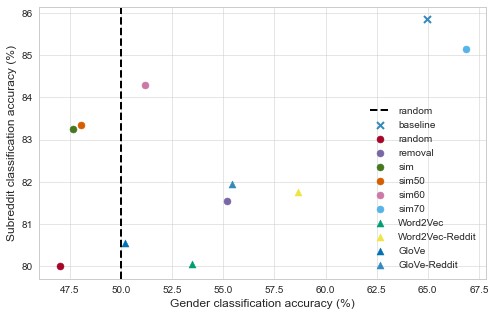

In [1509]:
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(8,5))

plt.scatter([64.95], [85.85], label='baseline', marker='x')
plt.scatter([47.00], [80.00], label='random')
plt.scatter([55.20], [81.55], label='removal')
plt.scatter([47.65], [83.25], label='sim')
plt.scatter([48.05], [83.35], label='sim50')
plt.scatter([51.15], [84.30], label='sim60')
plt.scatter([66.85], [85.15], label='sim70')
plt.axvline(x=50, color='k', linestyle='--', label='random')
plt.scatter([53.45], [80.05], label='Word2Vec' , marker='^')
plt.scatter([58.65], [81.75], label='Word2Vec-Reddit', marker='^')
plt.scatter([50.20], [80.55], label='GloVe', marker='^')
plt.scatter([55.40], [81.95], label='GloVe-Reddit', marker='^')

plt.xlabel('Gender classification accuracy (%)')
plt.ylabel('Subreddit classification accuracy (%)')

plt.legend()
plt.show()